In [5]:
import matplotlib
matplotlib.use('GTKagg')
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import numpy as np
import json
import string
import dataCoverage
import sys
import datetime
from ipywidgets import Dropdown # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from IPython.display import clear_output
import os, time

sys.path.append('../')
import senseapi

# default sourcename
defaultSourceName = 'sense-library'
sourceNames = ['sense-library', 'manual', 'google_fit', 'health_kit']
# default sensor names
sensorNames = ["noise", "accelerometer", "battery", "light", 
               "position", "proximity", "sleep", "sleep_estimate", 
               "time_active", "time_zone", "sense_log", "mental_resilience", "screen", "call", "app_info", 
               "activity", "speed", "distance", "step_count", "heart_rate"]
globalStartTime = None
globalEndTime = None

# Get user credentials
try:
    f = open('credentials.txt', 'r')
except:
    print 'missing credentials.txt with username,password and application_key json'
creds = json.load(f)
f.close()

try:
    username = creds['username']
    password = creds['password']
    appKey = creds['application_key']
except:
    print 'session_id authentication not available!'
    username = ''
    password = ''
    appKey = ''

# Set SensorApi settings
api = senseapi.SenseAPI()
api.setVerbosity(False)
api.setServer('dev')
api.setAppKey(appKey)
password_md5 = senseapi.MD5Hash(password)

# Login
if not api.AuthenticateSessionId(username, password_md5):
    print api.getError()
    exit()

# Set the data coverage settings
dataCoverage = dataCoverage.DataCoverage()
dataCoverage.setSimpleCoverage(False) # we use the complex coverage comparing individual points

# Get all the data for a sensor
def getSensorData(sensorName, getParameters, sourceName = defaultSourceName):
    sensorData = []
    lastTime = 0
    while True:
        # get data multiple times since there is a limit of 1000 points per call
        if api.SensorDataGet(sourceName, sensorName, getParameters):
            response = json.loads(api.getResponse())
            dataArray = response['data']
            # if there is no data then break, or if the last item is the same af previous round
            if len(dataArray) == 0 or lastTime == dataArray[len(dataArray)-1]["time"]:
                break
                
            # if this is the fist time then copy the whole response
            if len(sensorData) == 0:
                sensorData = dataArray
            # else don't copy the first item since, it's inclusive from the previous call
            else:
                sensorData += dataArray[1:]
                
            # we got less then the limit so we can stop now
            if len(dataArray) < 1000:
                break
                
            # get the time of the last item in the list
            lastTime = dataArray[len(dataArray)-1]["time"]
            # use the lastTime to select a new start period and get max 1000 points again
            getParameters['start_time'] = lastTime
        else:
            break
    return sensorData

def getSensorDataFrame(sensorName, start_time = None, end_time = None, sourceName = defaultSourceName):
    """
        Returns the data coverage for a specific sensor and a predefined sourceName
        @param sensorName (string) The sensor name to get the data for and compute the coverage for
        @param interval (int) The interval used for this sensor
        @return (float) The coverage percentage, a value between 0 and 1
         
    """
    
    getParameters = {"sort":"ASC", "limit":1000}
    if start_time != None:
        getParameters["start_time"] = start_time
    elif globalStartTime != None:
        getParameters["start_time"] = globalStartTime
    if end_time != None:
        getParameters["end_time"] = end_time
    elif globalEndTime != None:
        getParameters["end_time"] = globalEndTime
    
    # get all the sensor data
    sensorData = getSensorData(sensorName, getParameters, sourceName)
    if len(sensorData) == 0:
        return pd.DataFrame()
    sd = pd.DataFrame(sensorData)
    sd.index = pd.to_datetime(sd['time'],unit='ms')
    del sd['time']
    return sd

# Print the log
def printLog(logType = None, start_time = None, end_time = None, sourceName = defaultSourceName):
    """
        Prints the log for a specific logtype
    """
    sense_log = getSensorDataFrame("sense_log", start_time, end_time, sourceName)
    for i in range(0,sense_log.size):
        value = sense_log.value[i]
        time = sense_log.index[i]
        if logType == None or value["type"] == logType:
            print "{} {}\n{} : {}".format(time, value['type'], value['tag'], value['text'])
            
# Prints the data in a table
def printTable(sensor_name, start_time = None, end_time = None, sourceName = defaultSourceName):
    """
        Prints the data for a specific sensor_name
    """
    sensor_data = getSensorDataFrame(sensor_name, start_time, end_time, sourceName)
    for i in range(0,sensor_data.size):
        value = sensor_data.value[i]
        time = sensor_data.index[i]
        print "{}\n{}".format(time, value)

# Print the data coverage
def printCoverage(sensorName, interval, start_time = None, end_time = None, sourceName = defaultSourceName):
    """
        Returns the data coverage for a specific sensor and a predefined sourceName
        @param sensorName (string) The sensor name to get the data for and compute the coverage for
        @param interval (int) The interval used for this sensor
        @return (float) The coverage percentage, a value between 0 and 1
         
    """
    getParameters = {"sort":"ASC", "limit":1000}
    if start_time != None:
        getParameters["start_time"] = start_time
    elif globalStartTime != None:
        getParameters["start_time"] = globalStartTime
    if end_time != None:
        getParameters["end_time"] = end_time
    elif globalEndTime != None:
        getParameters["end_time"] = globalEndTime
    
    coverage = 0
    avgInterval = 0
    
    # get all the sensor data
    sensorData = getSensorData(sensorName, getParameters, sourceName)
    if len(sensorData) == 0:
        return
    coverage, avgInterval = dataCoverage.coverage(sensorData, interval, start_time, end_time)
    print "{:20} coverage: {:6}%   interval: {:<6} min".format(sensorName, round(coverage*100.0,2), round(avgInterval/60000.0, 2))

def plotCoverage(sensorName, interval, savePlot = False, showPlot = True, start_time = None, end_time = None, sourceName = defaultSourceName):
    """
        Returns the data coverage for a specific sensor and a predefined sourceName
        @param sensorName (string) The sensor name to get the data for and compute the coverage for
        @param interval (int) The interval used for this sensor
        @return (float) The coverage percentage, a value between 0 and 1
         
    """
    sd = getSensorDataFrame(sensorName, start_time, end_time, sourceName)
    if sd.size == 0:
        return
    sd = sd['value']
    sd = sd.resample("60 min", how='count').fillna(0)
    baseline = 60.0/(interval/(1000*60))
    plt.figure(figsize=(20,10))
    plt.plot(sd.index, (sd.values/baseline)*100.0)    
    plt.title("Coverage % per hour for sensor: "+sensorName)
    plt.ylim([-10,110])
    if showPlot:
        plt.show()
    if savePlot:
        savefig("{}-{}_{}.png".format(start_time, end_time, sensorName))

def dictToColumn(data):
    for key in data['value'][0]:
        data[key] = data['value'].apply( lambda t : t[key])
    del data['value']
    return data
    

/home/ted/Pworkspace/commonsense-python-lib/venv/local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [6]:
# Coverage Settings
os.environ['TZ'] = 'Europe/Amsterdam'
time.tzset()

# Sample rates
sampling3Minutes = 3 * 60 * 1000
sampling5Minutes = 5 * 60 * 1000
defaultSampleRate = sampling3Minutes

# start time
#globalStartTime = int(datetime.datetime(2015,12,25,22,0).strftime('%s'))*1000
#globalEndTime = int(datetime.datetime(2015,12,26,12,0).strftime('%s'))*1000
globalStartTime = int(datetime.datetime(2016,7,18,0,0).strftime('%s'))*1000
globalEndTime = int(datetime.datetime(2016,7,18,19,0).strftime('%s'))*1000
# print "start epoch: {}".format(globalStartTime)
# print "end epoch: {}".format(globalEndTime)
#globalStartTime = None
#globalEndTime = None


In [18]:
for sourceName in sourceNames:
    print "\nCoverage for source: {}\n".format(sourceName)
    # Print total coverage
    printCoverage("noise", defaultSampleRate, sourceName=sourceName)
    printCoverage("accelerometer", defaultSampleRate, sourceName=sourceName)
    printCoverage("battery", defaultSampleRate, sourceName=sourceName)
    printCoverage("light", defaultSampleRate, sourceName=sourceName)
    printCoverage("position", sampling5Minutes, sourceName=sourceName)
    printCoverage("proximity", defaultSampleRate, sourceName=sourceName)
    printCoverage("sleep", sampling5Minutes, sourceName=sourceName)
    printCoverage("sleep_estimate", sampling5Minutes, sourceName=sourceName)
    printCoverage("activity", defaultSampleRate, sourceName=sourceName)


    # extra event based sensors
    printCoverage("time_zone", defaultSampleRate, sourceName=sourceName)
    printCoverage("sense_log", defaultSampleRate, sourceName=sourceName)
    printCoverage("mental_resilience", defaultSampleRate, sourceName=sourceName)
    printCoverage("screen", defaultSampleRate, sourceName=sourceName)
    printCoverage("call", defaultSampleRate, sourceName=sourceName)
    printCoverage("app_info", defaultSampleRate, sourceName=sourceName)
    printCoverage("heart_rate", defaultSampleRate, sourceName=sourceName)
    printCoverage("speed", defaultSampleRate, sourceName=sourceName)
    printCoverage("distance", defaultSampleRate, sourceName=sourceName)
    printCoverage("step_count", defaultSampleRate, sourceName=sourceName)


Coverage for source: sense-library

noise                coverage:  23.71%   interval: 10.93  min
accelerometer        coverage:  69.89%   interval: 3.09   min
battery              coverage:  93.45%   interval: 3.19   min
light                coverage:  83.76%   interval: 3.55   min
position             coverage:  89.62%   interval: 3.44   min
screen               coverage:  26.93%   interval: 4.43   min
call                 coverage:  29.41%   interval: 1.91   min

Coverage for source: manual


Coverage for source: google_fit


Coverage for source: health_kit



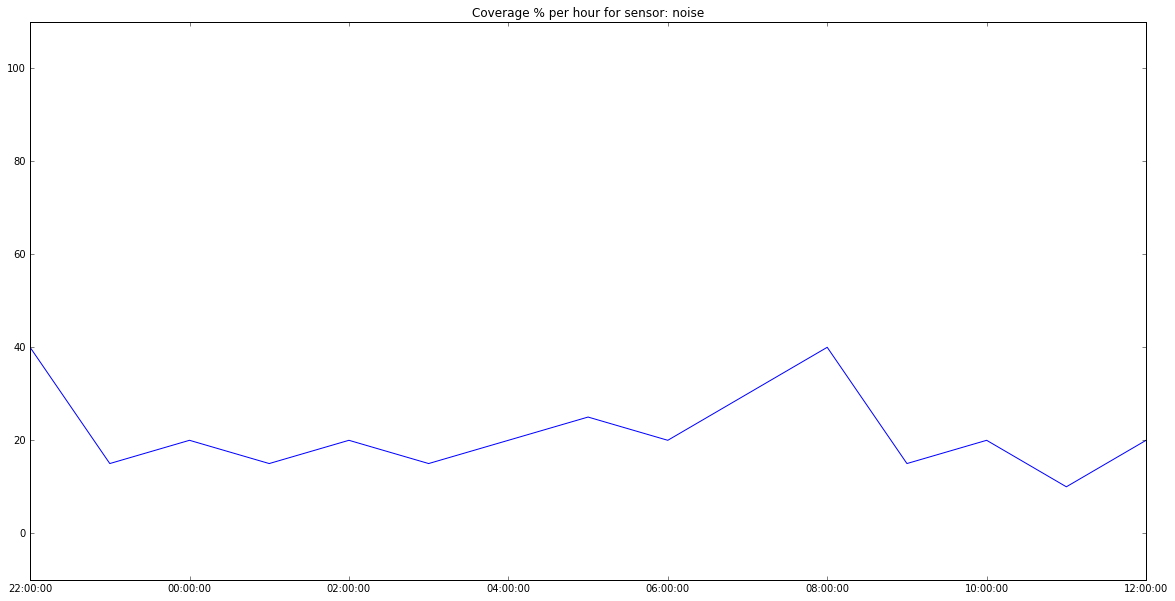

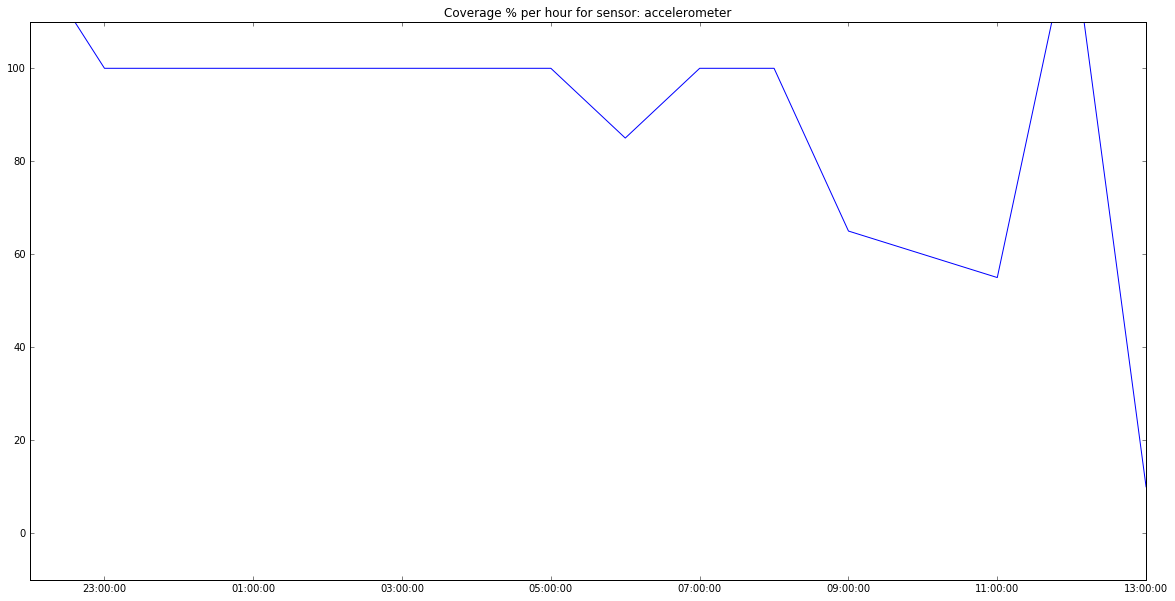

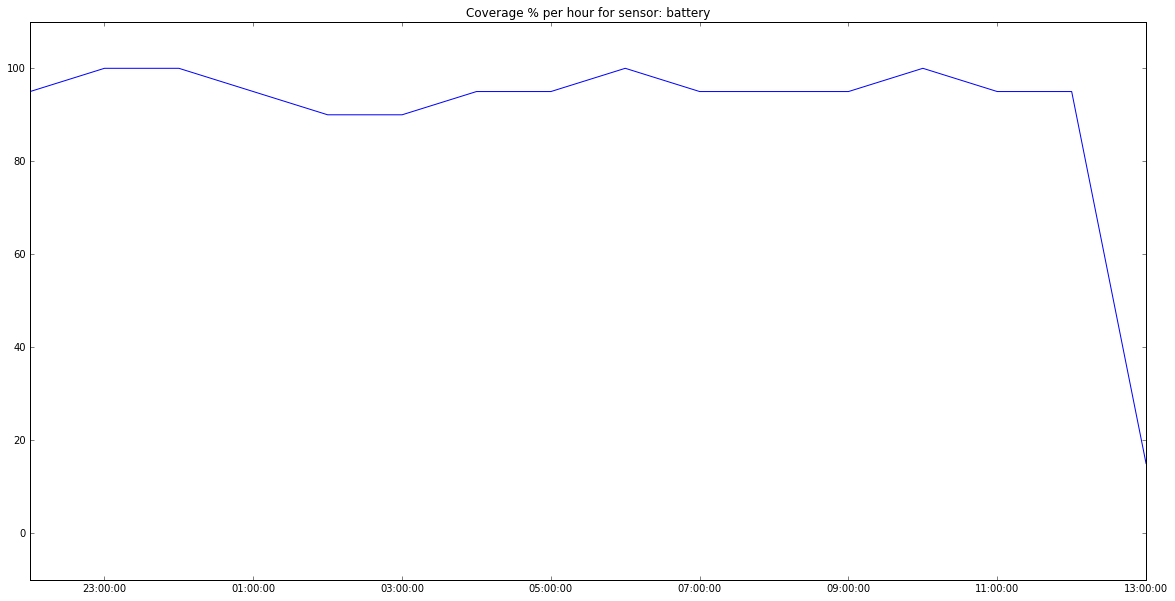

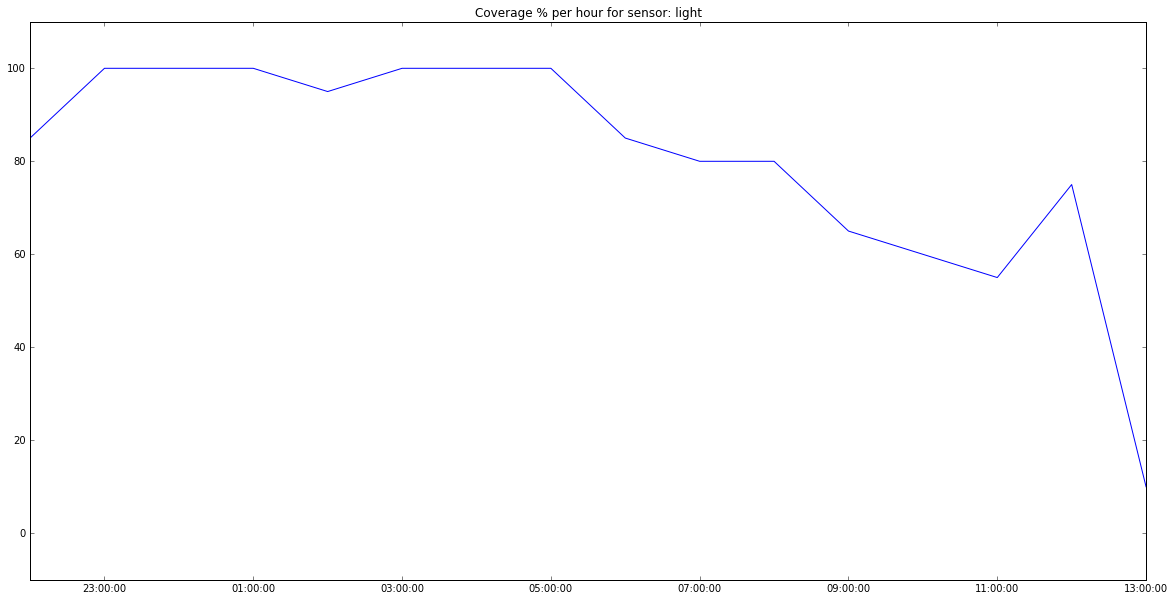

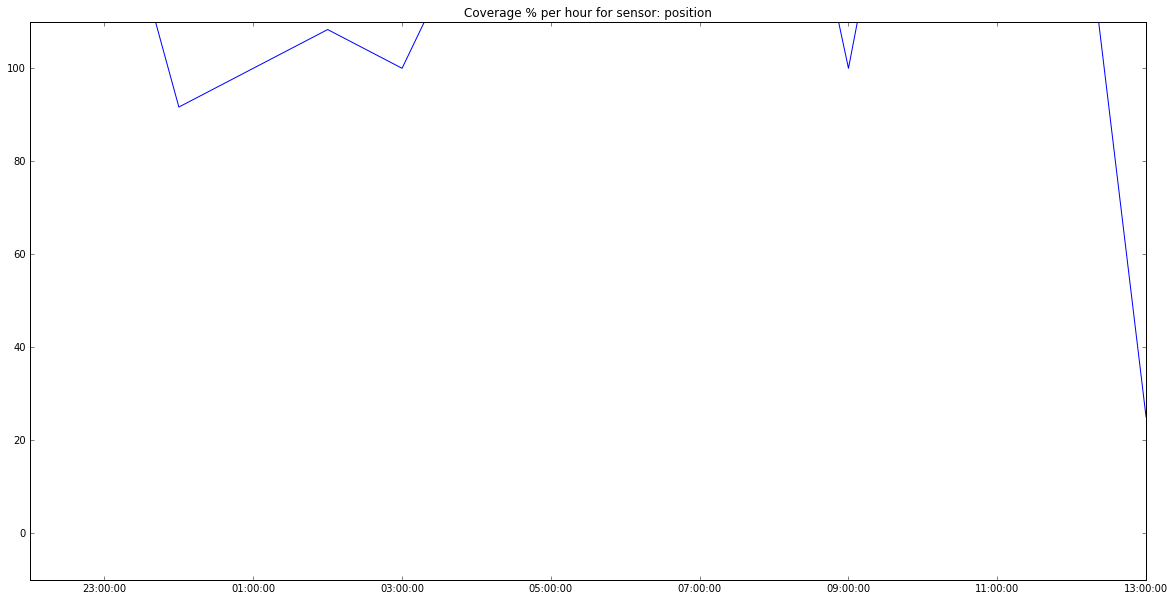

In [11]:
# plot coverage percentage
plotCoverage("noise", defaultSampleRate)
plotCoverage("accelerometer", defaultSampleRate)
plotCoverage("battery", defaultSampleRate)
plotCoverage("light", defaultSampleRate)
plotCoverage("position", sampling5Minutes)
plotCoverage("proximity", defaultSampleRate)
plotCoverage("sleep", sampling5Minutes)
plotCoverage("sleep_estimate", sampling5Minutes)
plotCoverage("time_active", defaultSampleRate)

In [ ]:
printLog("VERBOSE")

noise                coverage:  21.28%   interval: 13.62  min


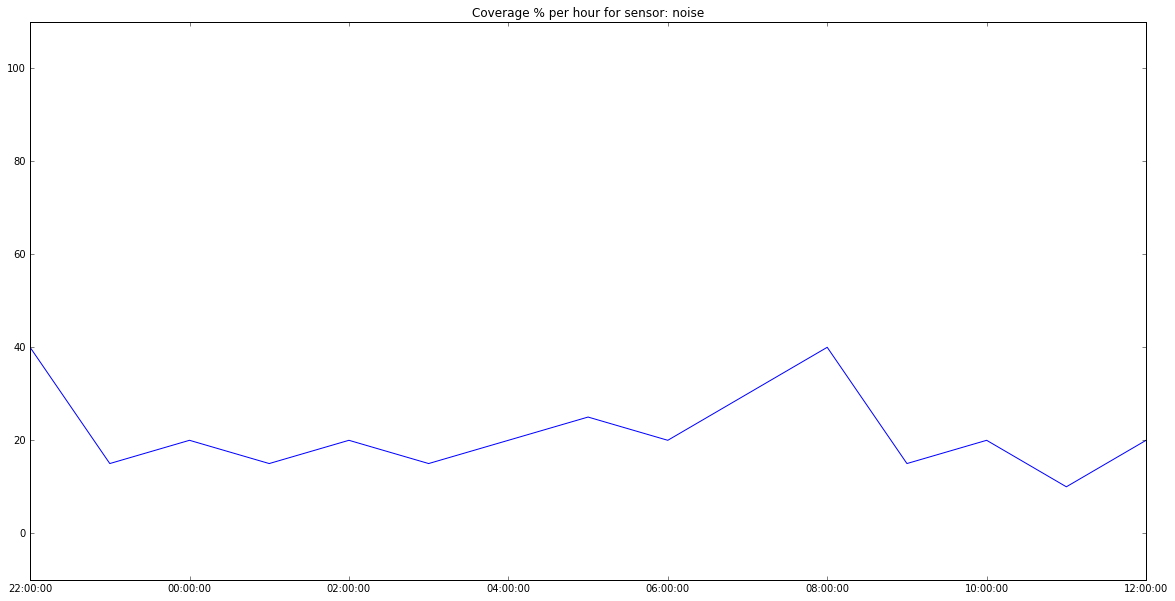

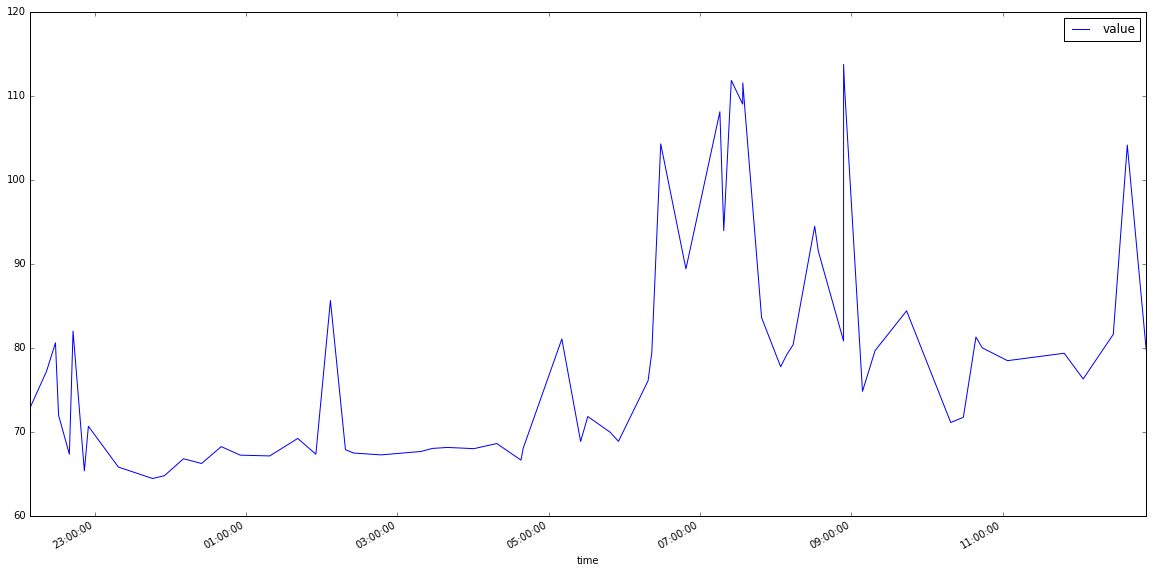

In [12]:
# plot sensor data
def on_sensor_select_change(name, value):
    clear_output()
    sourceName = sourceSelectWidget.selected_label
    printCoverage(value, defaultSampleRate, sourceName = sourceName)
    plotCoverage(value, defaultSampleRate, sourceName = sourceName)
    data = getSensorDataFrame(value, sourceName = sourceName)
    if data.size == 0:
        print "no data"
        return

    if value == "sleep" or value == "sleep_estimate":
        data['value'] = data['value'].apply( lambda t : t['sleepTime'])
    
    if value == "screen":
        data['value'] = data['value'].apply( lambda t : t == "on")
        
   
    
    # transform the 1 layer dict into a column 
    if isinstance(data.value[0], dict):
        data = dictToColumn(data)
    try:
        data.plot(figsize=(20,10))
        #plt.ylim(0,5)
    except:
        print data
        
sourceSelectWidget = Dropdown(description="Select a source",  options=[""]+sourceNames)
sensorSelectWidget = Dropdown(description="Select a sensor",  options=[""]+sensorNames)

display(sourceSelectWidget)
display(sensorSelectWidget)
sensorSelectWidget.on_trait_change(on_sensor_select_change, 'value')

In [10]:
printTable("activity")
#print getSensorDataFrame("sleep")['value']['value']['sleepTime']#[datetime.datetime(2016,1,27,8,30): datetime.datetime(2016,1,27,12,0)]

In [12]:
%matplotlib gtk
getSensorDataFrame("time_active").resample("1min", fill_method='ffill').dropna().diff(60).apply( lambda t : t / 60).plot(kind='bar')
plt.show()

In [9]:
getSensorDataFrame("activity", sourceName='google_fit')['value']

KeyError: 'value'